In [1]:
import numpy as np
import brighteyes_flim.flism as flim
import matplotlib.pyplot as plt
from scipy.signal import convolve
import os
import math
import brighteyes_ism.simulation.PSF_sim as sim
import brighteyes_ism.analysis.Graph_lib as gra
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.analysis.Deconv_lib as dec
import brighteyes_ism.analysis.FRC_lib as frc

import sys

import brighteyes_ism.analysis.APR_lib as apr

import brighteyes_ism.dataio.mcs as mcs

from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
import scipy.signal
from skimage.filters import gaussian

### IRF: calibration with solution of Rhodamine B in methanol

In [4]:
#"\\iitfsvge101.iit.local\mms\Data MMS server\STED-ISM\IRF calibration Rhodamine B\40 MHZ INT\calibration.h5"
data_irf, meta_irf = mcs.load(r"/mnt/iitfsvge101/MMS/Data MMS server/STED-ISM/IRF calibration Rhodamine B/40 MHZ INT/validation.h5")

data_irf = tool.CropEdge(data_irf, npx=10, edges='lrud', order = 'rzxytc')
#data = tools.DownSample(data, ds = 2, order = 'rzxytc')

In [5]:
print('Dataset IRF shape: ' + str(data_irf.shape) + '\n')
meta_irf.Print()

Dataset IRF shape: (1, 1, 492, 492, 91, 25)

version       0.0.1
comment       
rangex        20.439999999999998
rangey        20.439999999999998
rangez        0.0
nbin          91
dt            0.2
nx            512
ny            512
nz            1
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       4.75


In [7]:
data_irf_4D = data_irf.sum((0,1))
print(data_irf_4D.shape)

(492, 492, 91, 25)


In [20]:
data_hist_irf = data_irf.sum(axis = (0, 1, 2, 3))
print(data_hist_irf.shape)

(91, 25)


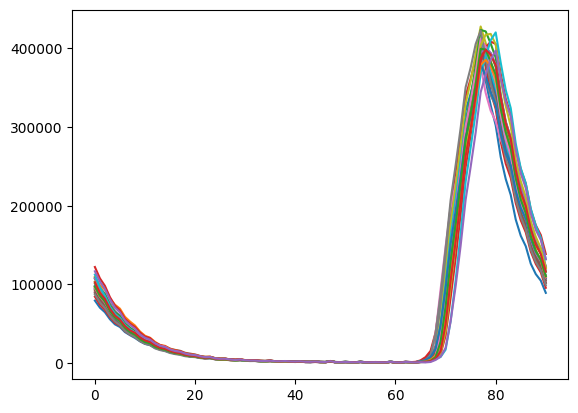

In [21]:
plt.figure()
for i in range(25):
    plt.plot(data_hist_irf[:,i])

### alignment: if you want to aligne the decay histograms of the 25 SPAD channels, you can use the align_decays function after computing the temporal shifts along the time bins using the function find_temporal_shifts

In [9]:
shift_vec_calib = flim.find_temporal_shifts(data_irf_4D)
print(shift_vec_calib.shape)

(25,)


/tmp/ipykernel_1772952/144086192.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist[:, 12], data_hist[:, i], upsample_factor=100, normalization=None)


In [13]:
decays_aligned = flim.align_decays(data_irf_4D, shift_vec_calib)

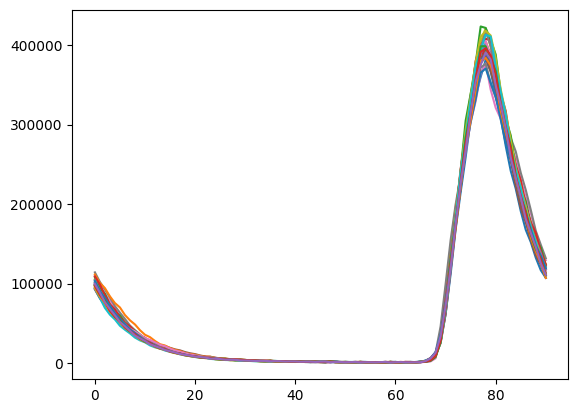

In [15]:
plt.figure()
for i in range(25):
    plt.plot(decays_aligned[:,i])

### alignment: if you want to aligne the decay histograms in each pixel of the 25 SPAD channels, you can use the align_image function after computing the temporal shifts along the time bins using the function find_temporal_shifts

In [12]:
image_calib_aligned = flim.align_image(data_irf_4D, shift_vec_calib)

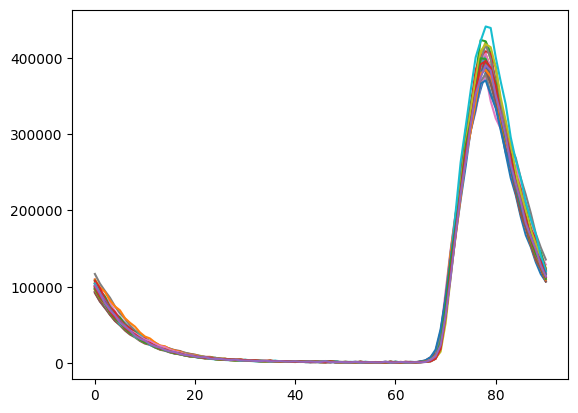

In [16]:
image_calib_aligned_sum = image_calib_aligned.sum((0,1))
plt.figure()
for i in range(25):
    plt.plot(image_calib_aligned_sum[:,i])

### Lifetime analysis on a biological sample: HeLa cells, TOMM20 Rabbit, AF 546

#### Dataset loading and visualization

In [32]:
#"\\iitfsvge101.iit.local\mms\Data MMS server\STED-ISM\AxialDeconvolution\unmixing\19_12_2025 H3K9 Star Red Tub AF647 TOMM20 Af 546 40 Mhz\TOMM20 green\data-19-12-2025-12-01-23.h5"
data_path= r'/mnt/iitfsvge101/MMS/Data MMS server/STED-ISM/AxialDeconvolution/unmixing/19_12_2025 H3K9 Star Red Tub AF647 TOMM20 Af 546 40 Mhz/TOMM20 green/data-19-12-2025-12-01-23.h5'   #data 
data_tomm20, meta_tomm20 = mcs.load(data_path)
data_tomm20 = tool.CropEdge(data_tomm20, npx=10, edges='lrud', order = 'rzxytc')
#data = tools.DownSample(data, ds = 2, order = 'rzxytc')
pxsizex_tomm20 = meta_tomm20.dx
print(pxsizex_tomm20)

0.0399609375


In [33]:
print('Dataset shape: ' + str(data_tomm20.shape) + '\n')
meta_tomm20.Print()

Dataset shape: (1, 1, 1004, 1004, 91, 25)

version       0.0.1
comment       
rangex        40.92
rangey        40.92
rangez        0.0
nbin          91
dt            1.5
nx            1024
ny            1024
nz            1
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       4.75


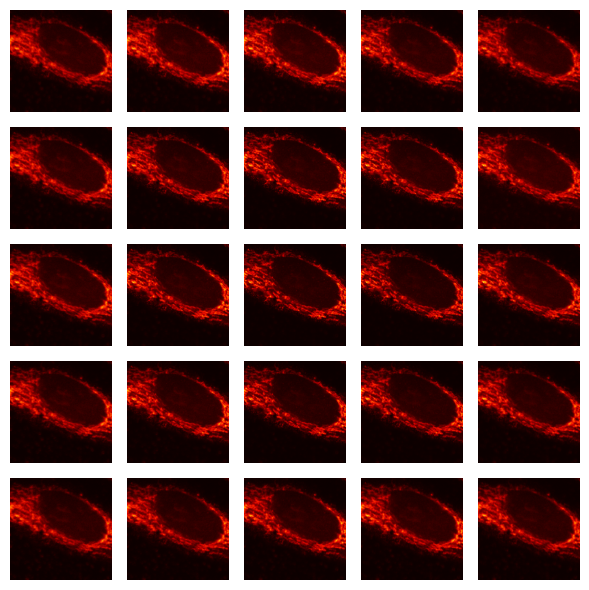

In [34]:
dset_tomm20 = data_tomm20.sum(axis = (0, 1, 4))
fig = gra.ShowDataset(dset_tomm20)

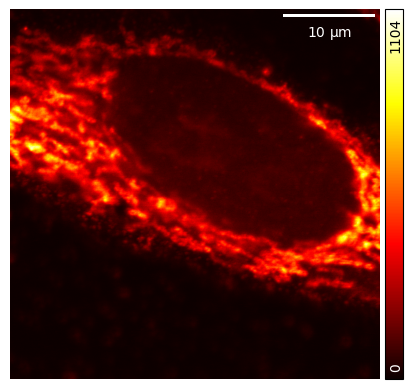

In [35]:
fig_tomm20 = gra.ShowImg(dset_tomm20.sum(-1), pxsizex_tomm20)

In [36]:
tomm20_data = data_tomm20.sum(axis = (0,1))
print(tomm20_data.shape)

(1004, 1004, 91, 25)


In [37]:
hists_tomm20 = data_tomm20.sum(axis = (0, 1,2,3))
print(hists_tomm20.shape)

(91, 25)


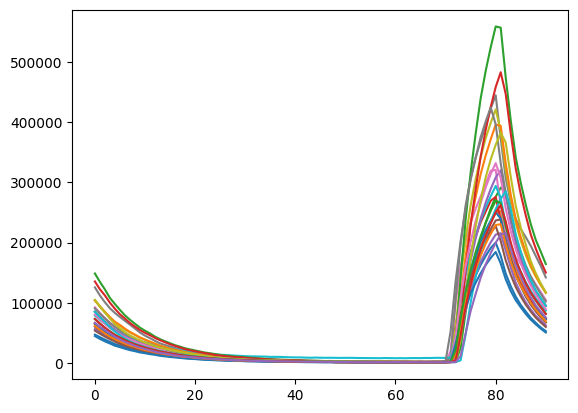

In [38]:
plt.figure()
for i in range(25):
    plt.plot(hists_tomm20[:,i])

### Lifetime estimation of the analyzed sample through phasor analysis and IRF calibration are performed within the method calibrate_phasor 

#### estimation on the sum of all the SPAD channels

In [39]:
phasors_pixels_calibrated_tomm20 = flim.calibrate_phasor(tomm20_data, data_irf_4D, tau_m_reference=2.5*10**-9, tau_phi_reference=2.5*10**-9 processing='Open confocal')
print(phasors_pixels_calibrated_tomm20.shape)

/tmp/ipykernel_1772952/3609268457.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist_irf[:,i], data_hist_input[:,i], upsample_factor=100, normalization=None)
/tmp/ipykernel_1772952/3609268457.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist[:, 12], data_hist[:, i], upsample_factor=100, normalization=None)


(1004, 1004)


/tmp/ipykernel_1772952/1836983583.py:350: RuntimeWarning: invalid value encountered in divide
  return np.where(flux < threshold, np.nan + 1j * np.nan, transform / flux)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

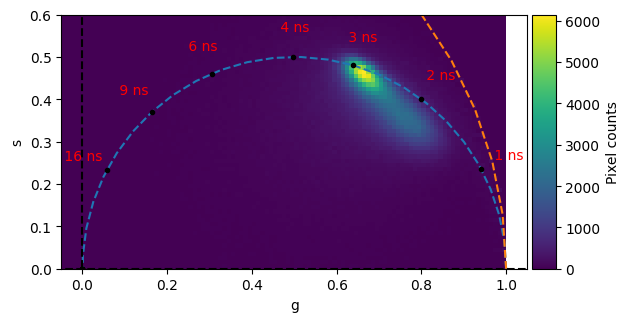

In [40]:
flim.plot_phasor(phasors_pixels_calibrated_tomm20, bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 40e6)

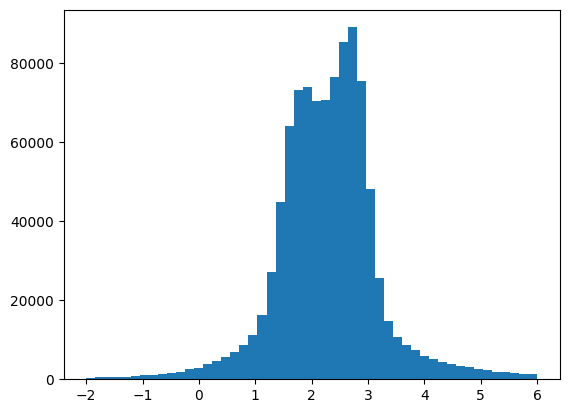

In [41]:
flim.show_lifetime_histogram(phasors_pixels_calibrated_tomm20)

### FLIM Map

#### FLIM image obtained with tau_phi estimation method

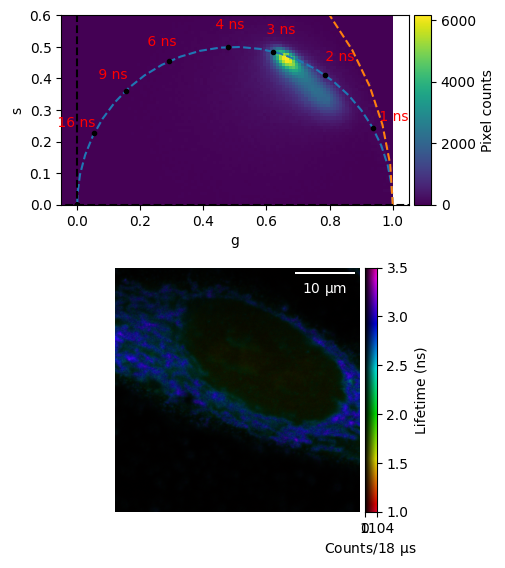

In [52]:
flim.plot_flim_image(tomm20_data, phasors_pixels_calibrated_tomm20, method='tau_phi', pxsize=0.04, pxdwelltime=18, lifetime_bounds=(1, 3.5), log_scale=False)

#### FLIM image obtained with tau_m estimation method

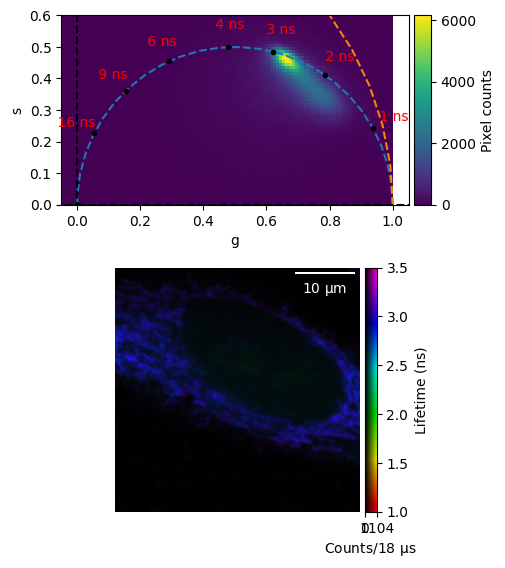

In [53]:
flim.plot_flim_image(tomm20_data, phasors_pixels_calibrated_tomm20, method='tau_m', pxsize=0.04, pxdwelltime=18, lifetime_bounds=(1, 3.5), log_scale=False)